#  Object Detection 시스템 만들기

* 실습 목표  
바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.  
Object detection 모델을 학습할 수 있습니다.  
Detection 모델을 활용한 시스템을 만들 수 있습니다.

* 학습 내용  
자율주행 보조장치  
RetinaNet  
keras-retinanet  
프로젝트: 자율주행 보조 시스템 만들기

## 자율주행 보조장치 (1) KITTI 데이터셋

* 자율주행 보조장치 object detection 요구사항

1) 사람이 카메라에 감지되면 정지  
2) 차량이 일정 크기 이상으로 감지되면 정지

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [3]:
# # 다운로드에 매우 긴 시간이 소요됩니다. 
# import urllib3
# urllib3.disable_warnings()
# (ds_train, ds_test), ds_info = tfds.load(
#     'kitti',
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )

Dl Completed...: |          | 0/0 [00:00<?, ? url/s]

Dl Size...: |          | 0/0 [00:00<?, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling kitti-train.tfrecord...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling kitti-validation.tfrecord...:   0%|          | 0/423 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling kitti-test.tfrecord...:   0%|          | 0/711 [00:00<?, ? examples/s]

Dataset kitti downloaded and prepared to /home/ssac26/tensorflow_datasets/kitti/3.2.0. Subsequent calls will reuse this data.


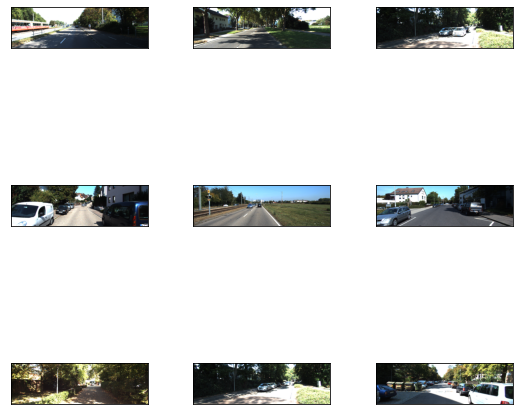

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/ssac26/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

## 자율주행 보조장치 (2) 데이터 직접 확인하기

In [6]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.69,  1.88,  1.78], dtype=float32)>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.28965333, 0.5526168 , 0.53194666, 0.63421094],
       [0.25376   , 0.30471015, 0.49944   , 0.4190016 ],
       [0.48762667, 0.4976731 , 0.5393867 , 0.52208537]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.57, 1.56, 2.62],
       [1.49, 1.53, 3.88],
       [1.5 , 1.7 , 3.77]], dtype=float32)>, 'location': <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 2.31,  1.64, 13.9 ],
       [-2.99,  1.81, 14.03],
       [ 1.9 ,  1.52, 58.35]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>, 'rotation_y': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.53,  1.68,  1.81], dtype=float32)>, 'truncated': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0

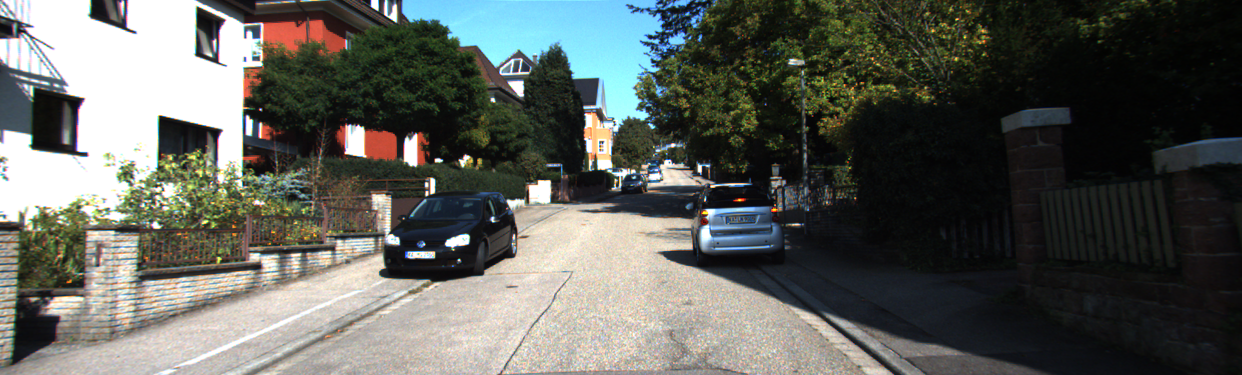

In [7]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242  height: 375
(3, 4)
[686.35004 266.38    787.69    175.52   ]
[378.45    279.84    520.4     187.70999]
[618.11    192.14    648.43005 172.73   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F47A8674090>


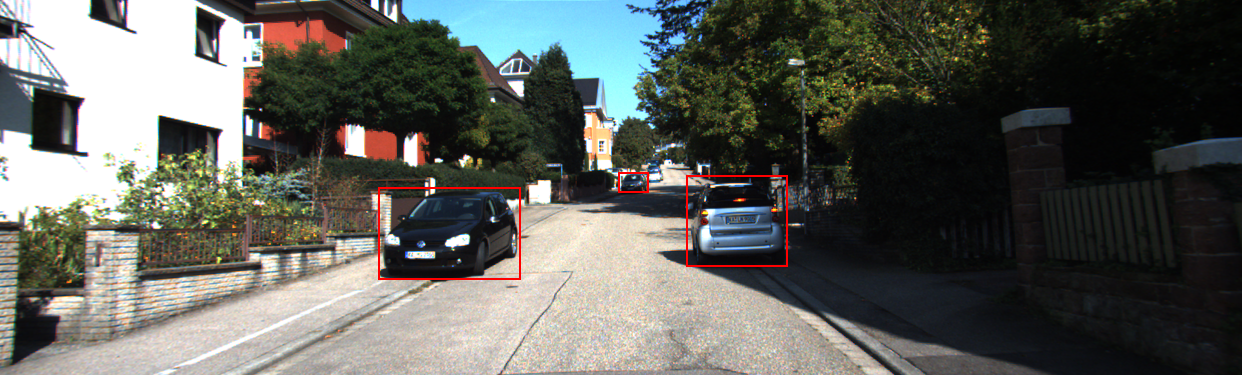

In [9]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

In [ ]:
# # 데이터셋 형식
# path/to/image.jpg,x1,y1,x2,y2,class_name

# # Example
# /data/imgs/img_001.jpg,837,346,981,456,cow
# /data/imgs/img_002.jpg,215,312,279,391,cat
# /data/imgs/img_002.jpg,22,5,89,84,bird
# /data/imgs/img_003.jpg,,,,,

# CSV로 저장할 때는 아래 코드를 참고해 주세요.

# # 데이터셋 저장 시 참고
# df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
# df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)

In [11]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [11:53<00:00,  8.90it/s]


테스트 데이터셋에 대해서도 동일하게 parse_dataset() 을 적용해서 dataframe을 생성해 봅시다.

In [12]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:29<00:00,  7.90it/s]


### 클래스 맵핑

In [ ]:
# class_name,id

# #Example
# cow,0
# cat,1
# bird,2

In [13]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## keras-retinanet 실습 (2) 셋팅

In [17]:
#!pip install progressbar2

Note: you may need to restart the kernel to use updated packages.


In [19]:
#!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=cf78ae9256ada5323cadae60d4b6fd82620081633cea523925f3f77a171b77e7
  Stored in directory: /home/ssac26/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
Note: you may need to restart the kernel to use updated packages.


In [20]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 12:15:47.371576: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 12:15:48.385452: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 12:15:48.389475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 12:15:48.389925: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 12:15:48.389949: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 12:15:48.392040: I tensorflow/stream_executor/platform

Epoch 1/50
2021-04-27 12:16:08.912242: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-27 12:16:10.382871: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-27 12:16:10.436263: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-27 12:16:10.825163: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
195/195 [==============================] - ETA: 0s - loss: 3.4146 - regression_loss: 2.6469 - classification_loss: 0.7677
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
2021-04-27 12:18:08.144953: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 18874368 exceeds 10% of free s

Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.4702 - regression_loss: 1.1317 - classification_loss: 0.3384
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 59s 303ms/step - loss: 1.4702 - regression_loss: 1.1317 - classification_loss: 0.3384
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.4118 - regression_loss: 1.0959 - classification_loss: 0.3159
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 59s 303ms/step - loss: 1.4118 - regression_loss: 1.0959 - classification_loss: 0.3159
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.4327 - regression_loss: 1.1178 - classification_loss: 0.3149
Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5
195/195 [==============================] - 59s 303ms/step - loss: 1.4327 - regression_loss: 1.1178 - classification_loss: 0.3149
Epoch 18/50
195/195 [==========

195/195 [==============================] - ETA: 0s - loss: 1.0046 - regression_loss: 0.7705 - classification_loss: 0.2340
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5
195/195 [==============================] - 59s 303ms/step - loss: 1.0046 - regression_loss: 0.7705 - classification_loss: 0.2340
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 0.9931 - regression_loss: 0.7512 - classification_loss: 0.2419
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 59s 303ms/step - loss: 0.9931 - regression_loss: 0.7512 - classification_loss: 0.2419
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 0.9826 - regression_loss: 0.7473 - classification_loss: 0.2353
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5
195/195 [==============================] - 59s 303ms/step - loss: 0.9826 - regression_loss: 0.7473 - classification_loss: 0.2353
Epoch 34/50
195/195 [======================

195/195 [==============================] - ETA: 0s - loss: 1.0262 - regression_loss: 0.7814 - classification_loss: 0.2448
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5
195/195 [==============================] - 59s 303ms/step - loss: 1.0262 - regression_loss: 0.7814 - classification_loss: 0.2448
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 0.9795 - regression_loss: 0.7407 - classification_loss: 0.2388
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.
195/195 [==============================] - 59s 303ms/step - loss: 0.9795 - regression_loss: 0.7407 - classification_loss: 0.2388
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 1.0201 - regression_loss: 0.7577 - classification_loss: 0.2624
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5
195/195 [==============================] - 59s 303ms/step - loss: 1.0201 - regression_loss:

아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합시다.

In [21]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 13:11:56.652586: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 13:11:58.342002: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 13:11:58.366685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 13:11:58.367255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 13:11:58.367295: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 13:11:58.372453: I tensorflow/stream_executor/platform

## keras-retinanet 실습 (3) 시각화

In [23]:
!pip install keras-retinanet

     |████████████████████████████████| 71 kB 60 kB/s  eta 0:00:01
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=167667 sha256=9f9999cb2423e44573d58ac756f126820a2318e5cc1550007183b6201f8512e3
  Stored in directory: /home/ssac26/.cache/pip/wheels/55/a1/41/f2dbc08b26549fe00041b9bc25c299f262b0311ad68cc52522
Successfully built keras-retinanet


In [24]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[594.4119  174.03442 626.0606  205.59265]
[186.7851  128.16129 360.85876 233.441  ]


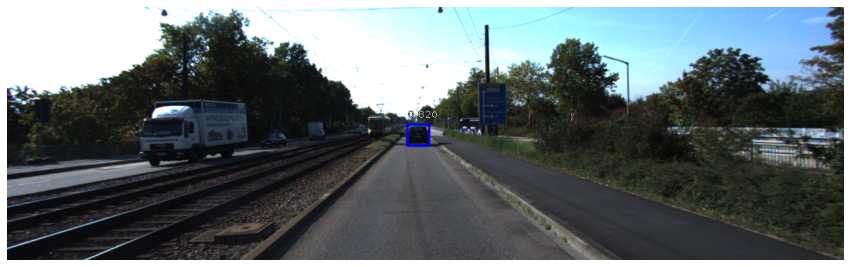

In [25]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[773.6964  149.24077 842.6954  317.00842]
[766.9171  154.52673 843.9651  314.5517 ]


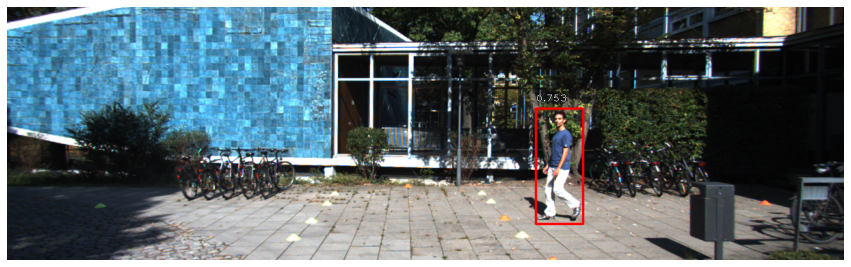

In [26]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

## 프로젝트: 자율주행 보조 시스템 만들기

### 1. 자율주행 시스템 만들기


위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.  
정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.  
조건은 다음과 같습니다.  
사람이 한 명 이상 있는 경우  
차량의 크기(width or height)가 300px이상인 경우  

In [41]:
def self_drive_assist(model, img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)
    
     # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        
    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0)  # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5:
            break
        b = box.astype(int)
        # 사람이 있는 경우
        if label == 1:
            result = "Stop"
        # 차량과 일정위치 이상 가까울때 (300px)
        if b[2] - b[0] >= size_limit or b[3] - b[1] >= size_limit:
            result = "Stop"
        
            
        
        draw_box(draw, b, color=color_map[label])

        caption = "{:.3f}".format(score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

    return result

### 2. 자율주행 시스템 평가하기

아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [43]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = self_drive_assist(model=model, img_path=image_path)

        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

[773.6964  149.24077 842.6954  317.00842]
[412.00607 164.81259 499.4305  334.56238]
[  0.      206.03333 310.81317 369.12827]
[755.4196  161.4271  887.8066  210.46132]


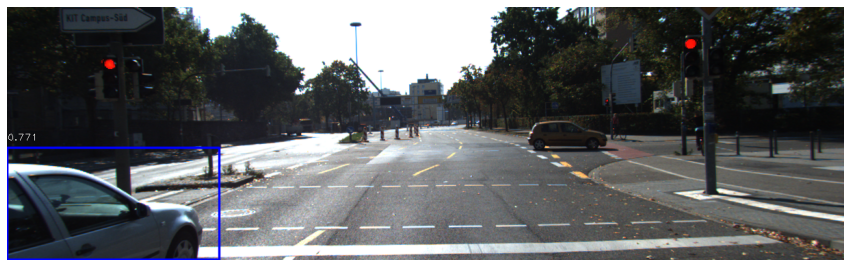

[ 720.91095    46.443737 1101.7196    361.98428 ]
[ 47.374615 161.81613  372.67896  307.17215 ]


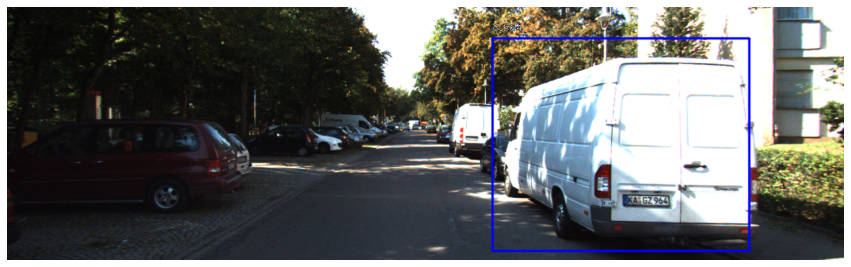

[ 873.8335   174.00102 1241.0684   371.18127]
[734.7471  164.16524 860.3007  244.05179]


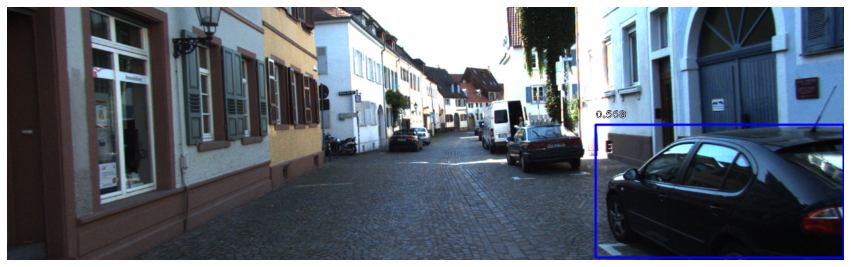

[594.4119  174.03442 626.0606  205.59265]
[186.7851  128.16129 360.85876 233.441  ]


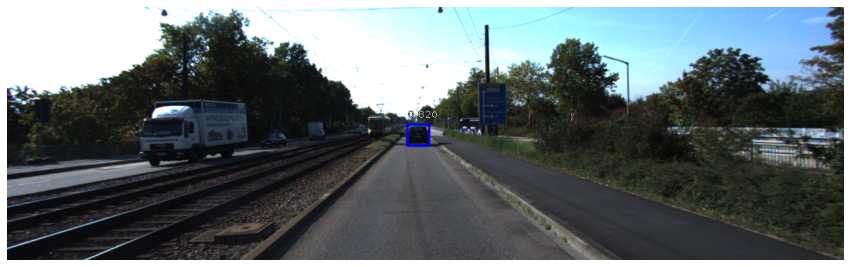

[627.2772  175.43446 667.7656  214.55951]
[515.45764 177.19176 569.929   214.62102]


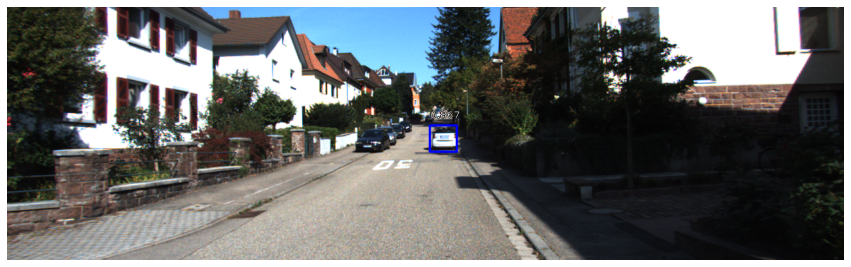

[809.03406 150.63333 883.852   178.85172]


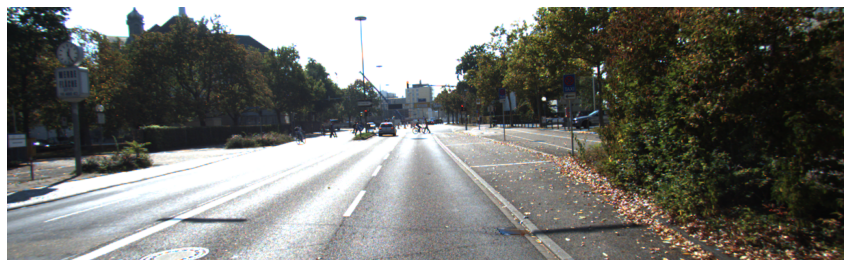

[694.6122  170.61957 794.25165 252.3122 ]
[708.13074 144.27724 789.25555 233.31421]


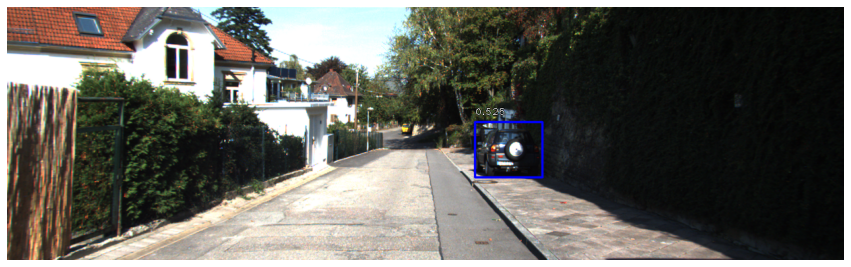

[  9.337219 189.43102  185.89566  309.3479  ]


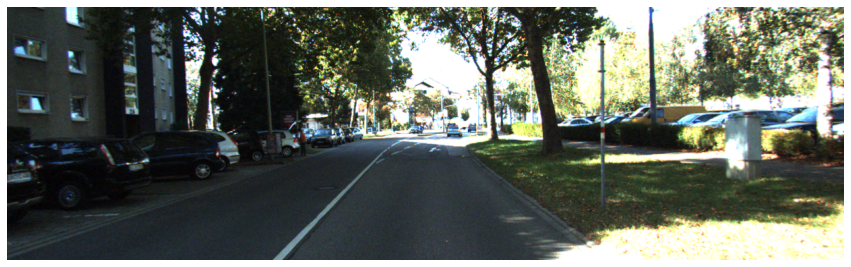

70점입니다.


In [44]:
test_system(self_drive_assist)

* 실습회고

object detection을 이용하여 분류하는 문제에서 그치지 않고 다른 문제 해결의 기초로 삼는 신기한 경험이었다.
go, stop에 대해 detection결과를 바탕으로 실험했지만 80점 아래의 점수가 나와서 아쉬웠다.  
